## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import datetime as dt
import re

import sklearn
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 500)
%matplotlib inline

## Read data

In [2]:
admin = pd.read_csv('../AirTracks/all_csv/Jan2017/admin.csv')

In [3]:
admin.head(2)

,FlightId,FlightCallsign,AircraftModel,AircraftRegistration,Airline,Origin,Destination,SchdeuledDeparture,ScheduledArrival,RealDeparture,EstimatedArrival,FlightTime
0,c244ac4,SAS1749,ATR 72-600,OY-JZE,SAS,Tallinn Lennart Meri Airport,Stockholm Arlanda Airport,1.484156e+09,1.484161e+09,1.484159e+09,NaN,3762.0
1,c32d217,OKA2925,Boeing 737-8AS,B-5578,OKAir,Changsha Huanghua International Airport,Hangzhou Xiaoshan International Airport,1.484694e+09,1.484698e+09,1.484694e+09,1.484698e+09,3850.0


## Rename columns

In [4]:
admin.rename(columns={
    'FlightId': 'flight_id',
    'FlightCallsign': 'flight_callsign',
    'AircraftModel': 'aircraft_model',
    'AircraftRegistration': 'aircraft_registration',
    'SchdeuledDeparture': 'scheduled_departure_utc',
    'ScheduledArrival': 'scheduled_arrival_utc',
    'RealDeparture': 'real_departure_utc',
    'EstimatedArrival': 'estimated_arrival_utc',
    'FlightTime': 'real_flight_duration'
     }, inplace=True)

admin.columns = admin.columns.map(lambda x: x.lower())

In [5]:
admin.columns

Index(['flight_id', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration'],
      dtype='object')

In [6]:
admin.dtypes

flight_id                   object
flight_callsign             object
aircraft_model              object
aircraft_registration       object
airline                     object
origin                      object
destination                 object
scheduled_departure_utc    float64
scheduled_arrival_utc      float64
real_departure_utc         float64
estimated_arrival_utc      float64
real_flight_duration       float64
dtype: object

## Handling null data

In [7]:
admin.isnull().sum()

flight_id                       0
flight_callsign              3851
aircraft_model              18818
aircraft_registration       20741
airline                     24109
origin                      41361
destination                 88792
scheduled_departure_utc     23538
scheduled_arrival_utc       23538
real_departure_utc          64318
estimated_arrival_utc      502967
real_flight_duration       160380
dtype: int64

In [8]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158127 entries, 0 to 1158126
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   flight_id                1158127 non-null  object 
 1   flight_callsign          1154276 non-null  object 
 2   aircraft_model           1139309 non-null  object 
 3   aircraft_registration    1137386 non-null  object 
 4   airline                  1134018 non-null  object 
 5   origin                   1116766 non-null  object 
 6   destination              1069335 non-null  object 
 7   scheduled_departure_utc  1134589 non-null  float64
 8   scheduled_arrival_utc    1134589 non-null  float64
 9   real_departure_utc       1093809 non-null  float64
 10  estimated_arrival_utc    655160 non-null   float64
 11  real_flight_duration     997747 non-null   float64
dtypes: float64(5), object(7)
memory usage: 106.0+ MB


In [9]:
str_cols = admin.columns[admin.dtypes==object]

In [10]:
# Fill NaN with empty string
admin[str_cols] = admin[str_cols].fillna('')

In [11]:
# Strip leading and trailing spaces in object columns
admin[str_cols] = admin[str_cols].apply(lambda x: x.str.strip())

In [12]:
# Drop duplicates
print(admin.shape)
admin.drop_duplicates(inplace=True)
print(admin.shape)

(1158127, 12)
(1158127, 12)


## Convert to datetime

In [13]:
admin['scheduled_departure_dt'] = pd.to_datetime(admin['scheduled_departure_utc'], unit='s')
admin['scheduled_arrival_dt'] = pd.to_datetime(admin['scheduled_arrival_utc'], unit='s')
admin['real_departure_dt'] = pd.to_datetime(admin['real_departure_utc'], unit='s')
admin['estimated_arrival_dt'] = pd.to_datetime(admin['estimated_arrival_utc'], unit='s')

**scheduled_arrival_utc, scheduled_departure_utc**

In [14]:
admin['scheduled_arrival_dt'][:5]

0   2017-01-11 18:55:00
1   2017-01-18 00:15:00
2   2017-01-17 22:55:00
3   2017-01-19 08:00:00
4   1970-01-01 00:00:00
Name: scheduled_arrival_dt, dtype: datetime64[ns]

In [15]:
admin['scheduled_departure_dt'][:5]

0   2017-01-11 17:40:00
1   2017-01-17 22:55:00
2   2017-01-17 18:40:00
3   2017-01-19 05:35:00
4   1970-01-01 00:00:00
Name: scheduled_departure_dt, dtype: datetime64[ns]

Observation: There are some dates where year = 1970. Check if there are dates that do not fall within Jan 2017

In [16]:
admin['scheduled_arrival_year'] = admin['scheduled_arrival_dt'].dt.year.astype('Int64')
admin['scheduled_arrival_month'] = admin['scheduled_arrival_dt'].dt.month.astype('Int64')
admin['scheduled_arrival_day'] = admin['scheduled_arrival_dt'].dt.day.astype('Int64')

In [17]:
admin['scheduled_departure_year'] = admin['scheduled_departure_dt'].dt.year.astype('Int64')
admin['scheduled_departure_month'] = admin['scheduled_departure_dt'].dt.month.astype('Int64')
admin['scheduled_departure_day'] = admin['scheduled_departure_dt'].dt.day.astype('Int64')

In [18]:
admin['scheduled_arrival_year'].value_counts(dropna=False).sort_index()

1970     128300
2016       6259
2017    1000030
NaN       23538
Name: scheduled_arrival_year, dtype: Int64

In [19]:
admin['scheduled_arrival_month'].value_counts(dropna=False).sort_index()

1      1128290
2           40
12        6259
NaN      23538
Name: scheduled_arrival_month, dtype: Int64

In [20]:
admin['scheduled_arrival_day'].value_counts(dropna=False).sort_index()

1      157774
2       33151
3       31973
4       31879
5       32668
6       37205
7       26926
8       13671
9       12090
10      14298
11      33701
12      25388
13      15876
14      32924
15      35911
16      36311
17      35286
18      35477
19      35485
20      36111
21      33482
22      36288
23      36726
24      37270
25      38889
26      41933
27      41784
28      38453
29      40717
30      40000
31      34942
NaN     23538
Name: scheduled_arrival_day, dtype: Int64

In [21]:
admin['scheduled_departure_year'].value_counts(dropna=False).sort_index()

1970    128300
2016      9114
2017    997175
NaN      23538
Name: scheduled_departure_year, dtype: Int64

In [22]:
admin['scheduled_departure_month'].value_counts(dropna=False).sort_index()

1      1125475
12        9114
NaN      23538
Name: scheduled_departure_month, dtype: Int64

In [23]:
admin['scheduled_departure_day'].value_counts(dropna=False).sort_index()

1      158007
2       33122
3       31935
4       31970
5       32842
6       36530
7       27556
8       10405
9       12721
10      16881
11      33827
12      22197
13      19149
14      33070
15      35961
16      36159
17      35332
18      35605
19      35324
20      36309
21      33623
22      36217
23      36779
24      37405
25      38918
26      42097
27      41719
28      38654
29      40656
30      39903
31      33716
NaN     23538
Name: scheduled_departure_day, dtype: Int64

In [24]:
admin['scheduled_arrival_dt'].isnull().sum()

23538

In [25]:
admin['scheduled_departure_dt'].isnull().sum()

23538

In [26]:
schedule_arrival_missing_index = admin.loc[admin['scheduled_arrival_dt'].isnull(), 'scheduled_arrival_dt'].index.tolist()
# # returns the same result
# admin['ScheduledArrival'][admin['ScheduledArrival'].isnull()].index

In [27]:
schedule_departure_missing_index = admin.loc[admin['scheduled_departure_dt'].isnull(), 'scheduled_departure_dt'].index.tolist()

In [28]:
np.array_equal(schedule_departure_missing_index, schedule_arrival_missing_index)

True

Observation: Rows with NaT for scheduled_arrival_dt also had NaT for scheduled_departure_dt

In [29]:
estimated_arrival_missing_index = admin.loc[admin['estimated_arrival_dt'].isnull(), 'estimated_arrival_dt'].index.tolist()

In [30]:
len(estimated_arrival_missing_index)

502967

In [31]:
len(list(set(estimated_arrival_missing_index).intersection(set(schedule_departure_missing_index))))

23538

Observation: EstimatedArrival shares common missing values for ScheduledArrival and ScheduledDeparture

In [32]:
admin['scheduled_flight_duration'] = admin['scheduled_arrival_utc'] - admin['scheduled_departure_utc']

**real_departure**

In [33]:
admin['real_departure_dt'].dt.year.value_counts(dropna=False)

2017.0    1084480
NaN         64318
2016.0       9329
Name: real_departure_dt, dtype: int64

In [34]:
# TODO: Check if there are common indices
# admin.dropna(subset=['real_departure_dt'], inplace=True)

**real_flight_duration**

In [35]:
admin.dtypes

flight_id                            object
flight_callsign                      object
aircraft_model                       object
aircraft_registration                object
airline                              object
origin                               object
destination                          object
scheduled_departure_utc             float64
scheduled_arrival_utc               float64
real_departure_utc                  float64
estimated_arrival_utc               float64
real_flight_duration                float64
scheduled_departure_dt       datetime64[ns]
scheduled_arrival_dt         datetime64[ns]
real_departure_dt            datetime64[ns]
estimated_arrival_dt         datetime64[ns]
scheduled_arrival_year                Int64
scheduled_arrival_month               Int64
scheduled_arrival_day                 Int64
scheduled_departure_year              Int64
scheduled_departure_month             Int64
scheduled_departure_day               Int64
scheduled_flight_duration       

In [36]:
# (admin['estimated_arrival'] - admin['real_departure'])[1].total_seconds()
(admin['estimated_arrival_utc'] - admin['real_departure_utc'])[1]

4135.0

In [37]:
admin.shape

(1093809, 23)

In [38]:
admin['real_flight_duration'].isnull().sum()

119761

In [39]:
real_flight_duration_null_idx = admin[admin['real_flight_duration'].isnull()].index.tolist()

In [40]:
real_departure_null_idx = admin[admin['real_departure_utc'].isnull()].index.tolist()

In [41]:
print(len(real_flight_duration_null_idx))
len(real_departure_null_idx)

119761


0

In [42]:
len(set(real_flight_duration_null_idx).intersection(real_departure_null_idx))

0

## Route

In [43]:
admin['route'] = admin.origin + " -> " + admin.destination

In [44]:
admin['route'].value_counts()[:20]

 ->                                                                                              13376
Seoul Gimpo International Airport -> Jeju International Airport                                   2039
Jeju International Airport -> Seoul Gimpo International Airport                                   1961
Sydney Kingsford Smith Airport -> Melbourne Airport                                               1553
Melbourne Airport -> Sydney Kingsford Smith Airport                                               1452
Ho Chi Minh City International Airport -> Hanoi Noi Bai International Airport                     1447
Hanoi Noi Bai International Airport -> Ho Chi Minh City International Airport                     1397
Delhi Indira Gandhi International Airport -> Mumbai Chhatrapati Shivaji International Airport     1230
Mumbai Chhatrapati Shivaji International Airport -> Delhi Indira Gandhi International Airport     1191
Taiwan Taoyuan International Airport -> Hong Kong International Airport  

In [45]:
admin.isnull().sum()

flight_id                         0
flight_callsign                   0
aircraft_model                    0
aircraft_registration             0
airline                           0
origin                            0
destination                       0
scheduled_departure_utc           0
scheduled_arrival_utc             0
real_departure_utc                0
estimated_arrival_utc        448716
real_flight_duration         119761
scheduled_departure_dt            0
scheduled_arrival_dt              0
real_departure_dt                 0
estimated_arrival_dt         448716
scheduled_arrival_year            0
scheduled_arrival_month           0
scheduled_arrival_day             0
scheduled_departure_year          0
scheduled_departure_month         0
scheduled_departure_day           0
scheduled_flight_duration         0
route                             0
dtype: int64

In [46]:
mask = admin['route'] == 'Taiwan Taoyuan International Airport -> Hong Kong International Airport'
df_twn_hkg = admin[mask]

In [47]:
# df_twn_hkg.sort_values(by='scheduled_departure_dt')['scheduled_departure_dt'].head(32)

In [48]:
df_twn_hkg[df_twn_hkg['real_flight_duration'].isnull()].index

Int64Index([  24196,  131209,  254181,  266773,  268583,  431010,  509209,
             631005,  708040,  792492,  833060,  860491,  930360,  957928,
             959131, 1034334, 1060331, 1069001, 1104197, 1157632],
           dtype='int64')

In [49]:
# (df_twn_hkg['scheduled_arrival_year'].dropna().astype(int).astype(str) + '-' + \
# df_twn_hkg['scheduled_arrival_month'].dropna().astype(int).astype(str) + '-' + \
# df_twn_hkg['scheduled_arrival_day'].dropna().astype(int).astype(str)) \
# .value_counts() \
# .sort_index()

# df_twn_hkg['scheduled_arrival_dt'].dt.date.value_counts(dropna=False).sort_index()

In [50]:
# df_twn_hkg['scheduled_departure_dt'].dt.date.value_counts(dropna=False).sort_index()

## Flights with scheduled arrival or scheduled departure in 1970

In [51]:
flights_in_1970 = df_twn_hkg[(df_twn_hkg['scheduled_arrival_dt'].dt.date == pd.Timestamp("1970-01-01 00:00:00")) | 
                             (df_twn_hkg['scheduled_departure_dt'].dt.date == pd.Timestamp("1970-01-01 00:00:00"))]
# flights_in_1970.sort_values(by='real_departure_dt')

In [52]:
flights_in_1970.shape

(31, 24)

In [53]:
# flights_in_1970['flight_callsign'].value_counts()

In [54]:
# flights_in_1970['aircraft_model'].value_counts()

In [55]:
# flights_in_1970['aircraft_registration'].value_counts()

In [56]:
# flights_in_1970['airline'].value_counts()

In [57]:
df_twn_hkg.loc[df_twn_hkg['airline'] == 'EVA Air Cargo', 'real_flight_duration'].value_counts()

4473.0    8
4151.0    8
5000.0    7
4300.0    4
5235.0    3
Name: real_flight_duration, dtype: int64

## Arrivals at Hong Kong International Airport

In [58]:
df_arrivals_at_hkg = admin[admin['destination'] == 'Hong Kong International Airport']
df_arrivals_at_hkg.reset_index(inplace=True)
df_arrivals_at_hkg.head()

,index,flight_id,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
0,60,c37d285,CAL680,Airbus A330-302,B-18302,China Airlines,Jakarta Soekarno Hatta International Airport,Hong Kong International Airport,1.484869e+09,1.484885e+09,1.484871e+09,NaN,15588.0,2017-01-19 23:35:00,2017-01-20 04:10:00,2017-01-20 00:01:56,NaT,2017,1,20,2017,1,19,16500.0,Jakarta Soekarno Hatta International Airport -...
1,77,c1774c7,CPA3259,Boeing 747-467F(ER),B-LID,Cathay Pacific Cargo,Shanghai Pudong International Airport,Hong Kong International Airport,1.483675e+09,1.483685e+09,1.483677e+09,NaN,7960.0,2017-01-06 03:50:00,2017-01-06 06:50:00,2017-01-06 04:21:57,NaT,2017,1,6,2017,1,6,10800.0,Shanghai Pudong International Airport -> Hong ...
2,112,c0ffaf5,FDX5392,Boeing 777-F28,N880FD,FedEx,Seoul Incheon International Airport,Hong Kong International Airport,0.000000e+00,0.000000e+00,1.483422e+09,NaN,NaN,1970-01-01 00:00:00,1970-01-01 00:00:00,2017-01-03 05:40:16,NaT,1970,1,1,1970,1,1,0.0,Seoul Incheon International Airport -> Hong Ko...
3,215,c4616a7,HKE1687,Airbus A321-231,B-LEA,HK Express,Osaka Kansai International Airport,Hong Kong International Airport,1.485407e+09,1.485423e+09,1.485410e+09,NaN,15017.0,2017-01-26 05:10:00,2017-01-26 09:35:00,2017-01-26 05:47:05,NaT,2017,1,26,2017,1,26,15900.0,Osaka Kansai International Airport -> Hong Kon...
4,232,c2c2b3e,CES721,Airbus A330-343,B-6126,China Eastern Airlines (People's Daily Online cs),Shanghai Hongqiao International Airport,Hong Kong International Airport,1.484440e+09,1.484449e+09,1.484444e+09,NaN,7990.0,2017-01-15 00:25:00,2017-01-15 02:50:00,2017-01-15 01:27:36,NaT,2017,1,15,2017,1,15,8700.0,Shanghai Hongqiao International Airport -> Hon...


In [59]:
df_arrivals_at_hkg.shape

(13915, 25)

In [60]:
df_arrivals_at_hkg['scheduled_arrival_dt'].value_counts().sort_index()

1970-01-01 00:00:00    576
2016-12-31 13:15:00      1
2016-12-31 15:30:00      1
2016-12-31 15:35:00      2
2016-12-31 15:55:00      2
                      ... 
2017-01-31 22:40:00      1
2017-01-31 22:50:00      1
2017-01-31 22:55:00      2
2017-01-31 23:00:00      1
2017-02-01 00:05:00      1
Name: scheduled_arrival_dt, Length: 6152, dtype: int64

In [61]:
df_arrivals_at_hkg.loc[df_arrivals_at_hkg['scheduled_arrival_dt'].dt.year == 1970, 'real_departure_dt'].isnull().sum()

0

## Trails

In [62]:
trails = pd.read_feather('../AirTracks/all_csv/Jan2017/trails.feather')

In [63]:
trails.rename(columns={
    'FlightId': 'flight_id',
    'Timestamp': 'timestamp_utc'
     }, inplace=True)

trails.columns = trails.columns.map(lambda x: x.lower())

## Merge trails and df_twn_hkg

In [64]:
trails[trails.flight_id.isin(df_twn_hkg.flight_id.unique())].shape

(289650, 7)

In [65]:
combined_twn_hkg = pd.merge(trails,
                            df_twn_hkg,
                            on='flight_id')
# del trails, df_twn_hkg

In [66]:
combined_twn_hkg.shape

(289650, 30)

In [67]:
combined_twn_hkg.head(3)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
0,c36108c,1484814608,25.078995,121.237640,0,317,0,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...
1,c36108c,1484814671,25.078762,121.237846,0,317,9,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...
2,c36108c,1484814702,25.078505,121.238098,0,312,10,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,2017,1,19,2017,1,19,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [68]:
combined_twn_hkg.sort_values(by=['flight_id', 'timestamp_utc'],
                             inplace=True)

In [69]:
combined_twn_hkg[combined_twn_hkg.duplicated(subset=['flight_id', 'timestamp_utc'])]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
136314,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [70]:
combined_twn_hkg[(combined_twn_hkg['flight_id'] == 'c126012') &
                 (combined_twn_hkg['timestamp_utc'] == 1483506833)]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_arrival_year,scheduled_arrival_month,scheduled_arrival_day,scheduled_departure_year,scheduled_departure_month,scheduled_departure_day,scheduled_flight_duration,route
136313,c126012,1483506833,22.684389,118.088074,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...
136314,c126012,1483506833,22.582352,117.917992,34000,237,461,CPA475,Boeing 777-367(ER),B-KPQ,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483500e+09,1.483508e+09,1.483505e+09,1.483510e+09,5725.0,2017-01-04 03:20:00,2017-01-04 05:25:00,2017-01-04 04:35:52,2017-01-04 06:14:21,2017,1,4,2017,1,4,7500.0,Taiwan Taoyuan International Airport -> Hong K...


In [71]:
combined_twn_hkg.loc[136313-3:136313+4, ['flight_id', 'timestamp_utc', 'latitude', 
                                         'longitude', 'heading', 'speed']]

,flight_id,timestamp_utc,latitude,longitude,heading,speed
136310,c126012,1483506598,22.827221,118.327026,237,459
136311,c126012,1483506673,22.739691,118.180527,237,460
136312,c126012,1483506723,22.684389,118.088074,237,460
136313,c126012,1483506833,22.684389,118.088074,237,461
136314,c126012,1483506833,22.582352,117.917992,237,461
136315,c126012,1483506938,22.434130,117.668556,237,462
136316,c126012,1483507003,22.357731,117.540176,237,461
136317,c126012,1483507018,22.345169,117.511490,247,461


Drop 136313 since it has the same latitude and longitude as 136312

In [72]:
combined_twn_hkg = combined_twn_hkg.drop(136313)
combined_twn_hkg.shape

(289649, 30)

## Plot of all flights (Taiwan Taoyuan International Airport -> Hong Kong International Airport)

In [73]:
# Reference: https://pbpython.com/pandas-qcut-cut.html
# Reference: https://stackoverflow.com/questions/50145702/pandas-cut-doesnt-bin-zero-values
cut_labels = ['0 <= speed <= 100', 
              '100 < speed <= 200',
              '200 < speed <= 300',
              '300 < speed <= 400',
              '400 < speed <= 500',
              '500 < speed <= 600',
              '600 < speed <= 700',
              '700 < speed <= 800']
cut_bins = [-np.inf, 100, 200, 300, 400, 500, 600, 700, 800]
combined_twn_hkg['speed_interval'] = pd.cut(combined_twn_hkg['speed'], bins=cut_bins, labels=cut_labels)

# pd.cut(combined_jkt_sin['speed'], bins=np.linspace(0, 800, 9))

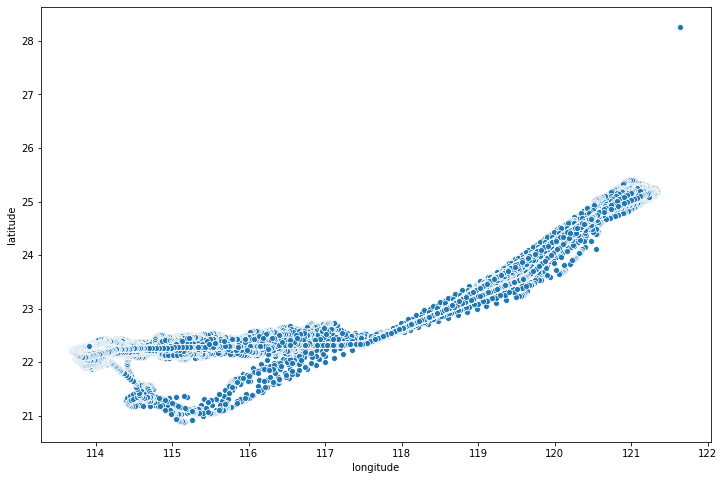

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', data=combined_twn_hkg)
plt.show()

In [75]:
combined_twn_hkg['time_since_real_departure'] = combined_twn_hkg['timestamp_utc'] - combined_twn_hkg['real_departure_utc']

In [76]:
combined_twn_hkg.loc[combined_twn_hkg['latitude'] > 28, trails.columns]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0


In [77]:
combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == 'c31cf95', 
                     trails.columns].sort_values(by='timestamp_utc').head(5)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0
27372,c31cf95,1484662641,24.921299,120.893318,19450,256,0
27373,c31cf95,1484662667,24.853016,120.848541,20684,230,390
27374,c31cf95,1484662677,24.837517,120.830132,21338,219,454
27375,c31cf95,1484662694,24.831850,120.808067,22190,258,329


In [78]:
# Shift latitude and longitude by 1
# for comparison of distance
unique_flight_ids = combined_twn_hkg.flight_id.unique().tolist()

df_prev_lat_lon = pd.DataFrame(columns=['flight_id', 'timestamp_utc', 'prev_latitude', 'prev_longitude'])

for flight_id in unique_flight_ids:
    dummy_df = combined_twn_hkg.loc[combined_twn_hkg['flight_id'] == flight_id, 
                                    ['flight_id', 'timestamp_utc', 'latitude', 'longitude']]
    dummy_df[['latitude', 'longitude']] = dummy_df[['latitude', 'longitude']].shift(1)
    dummy_df.rename(columns={'latitude': 'prev_latitude',
                             'longitude': 'prev_longitude'}, inplace=True)
    df_prev_lat_lon = pd.concat([df_prev_lat_lon, dummy_df])
df_prev_lat_lon

,flight_id,timestamp_utc,prev_latitude,prev_longitude
87466,c0aabc0,1483193923,NaN,NaN
87467,c0aabc0,1483193942,25.089270,121.240158
87468,c0aabc0,1483194080,25.089512,121.240349
87469,c0aabc0,1483194271,25.089546,121.240372
87470,c0aabc0,1483194304,25.089550,121.240372
...,...,...,...,...
227460,c52959e,1485870339,22.308723,113.916298
227461,c52959e,1485870348,22.308483,113.916603
227462,c52959e,1485870355,22.308449,113.916817
227463,c52959e,1485870366,22.308659,113.916946


In [79]:
merged_df = pd.merge(combined_twn_hkg,
                     df_prev_lat_lon,
                     how='left',
                     left_on=['flight_id', 'timestamp_utc'],
                     right_on=['flight_id', 'timestamp_utc'])
merged_df.shape

(289649, 34)

In [80]:
selected_col = trails.columns.tolist()
selected_col.extend(['real_flight_duration', 'real_departure_utc', 'real_departure_dt', 
                     'time_since_real_departure'])

**altitude > 0 but speed <= 0. Possibly erroneous**

In [81]:
merged_df.loc[(merged_df['speed'] <= 0) & (merged_df['altitude'] > 0), 
              selected_col]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
142312,c31cf95,1484662603,28.258541,121.633163,11600,8,0,4724.0,1.484662e+09,2017-01-17 14:10:37,366.0
142313,c31cf95,1484662641,24.921299,120.893318,19450,256,0,4724.0,1.484662e+09,2017-01-17 14:10:37,404.0
152134,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 11:53:45,1.0
152135,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 11:53:45,9.0
152136,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 11:53:45,15.0
152416,c33e9e8,1484746201,22.294333,113.895111,50,71,0,5746.0,1.484740e+09,2017-01-18 11:53:45,5776.0
228697,c4490d9,1485359074,24.110689,120.543747,14325,0,0,4663.0,1.485359e+09,2017-01-25 15:37:43,411.0
228698,c4490d9,1485359127,25.075544,120.854759,22050,343,0,4663.0,1.485359e+09,2017-01-25 15:37:43,464.0


In [82]:
merged_df.loc[merged_df['flight_id'] == 'c4490d9'].shape

(35, 34)

In [83]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
142312,c31cf95,1484662603,28.258541,121.633163,11600,8,0,4724.0,1.484662e+09,2017-01-17 14:10:37,366.0
142313,c31cf95,1484662641,24.921299,120.893318,19450,256,0,4724.0,1.484662e+09,2017-01-17 14:10:37,404.0
142314,c31cf95,1484662667,24.853016,120.848541,20684,230,390,4724.0,1.484662e+09,2017-01-17 14:10:37,430.0
142315,c31cf95,1484662677,24.837517,120.830132,21338,219,454,4724.0,1.484662e+09,2017-01-17 14:10:37,440.0
142316,c31cf95,1484662694,24.831850,120.808067,22190,258,329,4724.0,1.484662e+09,2017-01-17 14:10:37,457.0
142317,c31cf95,1484662709,24.831102,120.788239,22980,287,301,4724.0,1.484662e+09,2017-01-17 14:10:37,472.0
142318,c31cf95,1484662719,24.845474,120.779282,23427,320,348,4724.0,1.484662e+09,2017-01-17 14:10:37,482.0
142319,c31cf95,1484662729,24.866079,120.764854,24134,330,404,4724.0,1.484662e+09,2017-01-17 14:10:37,492.0
142320,c31cf95,1484662736,24.871128,120.760094,24283,319,378,4724.0,1.484662e+09,2017-01-17 14:10:37,499.0
142321,c31cf95,1484662742,24.881048,120.749977,24514,318,374,4724.0,1.484662e+09,2017-01-17 14:10:37,505.0


In [84]:
# Drop flights with flight_id c4490d9, c31cf95. 
# Reason being that the are multiple records with altitude > 0 but speed = 0 in between records
merged_df.drop(merged_df[(merged_df['flight_id'].isin(['c4490d9', 'c31cf95']))].index, inplace=True)

In [85]:
# Don't drop because the records with altitude > 0 but speed = 0
# are at the start of the flight
merged_df.loc[(merged_df['flight_id'] == 'c33e9e8'), 
               selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,real_flight_duration,real_departure_utc,real_departure_dt,time_since_real_departure
152127,c33e9e8,1484740121,25.059814,121.229324,0,225,21,5746.0,1.484740e+09,2017-01-18 11:53:45,-304.0
152128,c33e9e8,1484740373,25.053635,121.227264,0,50,20,5746.0,1.484740e+09,2017-01-18 11:53:45,-52.0
152129,c33e9e8,1484740379,25.054150,121.227951,0,50,46,5746.0,1.484740e+09,2017-01-18 11:53:45,-46.0
152130,c33e9e8,1484740389,25.056210,121.230698,0,50,88,5746.0,1.484740e+09,2017-01-18 11:53:45,-36.0
152131,c33e9e8,1484740399,25.059471,121.234993,0,50,120,5746.0,1.484740e+09,2017-01-18 11:53:45,-26.0
152132,c33e9e8,1484740405,25.061531,121.237564,0,50,140,5746.0,1.484740e+09,2017-01-18 11:53:45,-20.0
152133,c33e9e8,1484740420,25.067184,121.244965,0,49,0,5746.0,1.484740e+09,2017-01-18 11:53:45,-5.0
152134,c33e9e8,1484740426,25.070297,121.248878,50,48,0,5746.0,1.484740e+09,2017-01-18 11:53:45,1.0
152135,c33e9e8,1484740434,25.076294,121.256813,525,50,0,5746.0,1.484740e+09,2017-01-18 11:53:45,9.0
152136,c33e9e8,1484740440,25.079367,121.260925,775,51,0,5746.0,1.484740e+09,2017-01-18 11:53:45,15.0


## Filter flights from TWN that landed in HKG

In [86]:
unique_flight_ids = merged_df['flight_id'].unique()
incomplete_flights = []
complete_flights = []
filtered_df = pd.DataFrame(columns=merged_df.columns.tolist() + ['calculated_flight_duration'])

for unique_flight_id in unique_flight_ids:
    # Filter to get records where 
    # plane has taken off; i.e. speed > 0
    # plane's time_since_real_departure >= 0
    temp = merged_df.loc[(merged_df['flight_id'] == unique_flight_id) &
                         (merged_df['time_since_real_departure'] >= 0) 
                         & (merged_df['speed'] > 0)].sort_values(by='timestamp_utc')
#                          , selected_col].sort_values(by='timestamp_utc')
    
    # time_since_real_departure after arrival 
    # where altitude = 0
#     if 0 in temp['altitude'][:10]:
#         print("ZERO ALTITUDE IN FIRST 10")
    possible_arrival_df = temp.loc[(temp['altitude'] == 0) & 
                                   (temp['time_since_real_departure'] > 11)] # setting to 0 will reveal that some planes did not take off successfully at the first attempt; > 0 then back to 0
    
    if possible_arrival_df.shape[0] > 0:
        complete_flights.append(unique_flight_id)
        calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
        temp = temp[temp['time_since_real_departure'] <= calculated_flight_duration]
        temp = temp.assign(calculated_flight_duration=calculated_flight_duration)
        filtered_df = filtered_df.append(temp, ignore_index=True)
    else:
        incomplete_flights.append(unique_flight_id)

print("Number of complete flights: {}".format(len(complete_flights)))
print("Number of incomplete flights: {}".format(len(incomplete_flights)))

Number of complete flights: 788
Number of incomplete flights: 357


In [87]:
# Convert to int
for col in ['altitude', 'heading', 'speed', 
           'scheduled_arrival_year', 'scheduled_arrival_month', 
            'scheduled_arrival_day', 'scheduled_departure_year', 
            'scheduled_departure_month', 'scheduled_departure_day']:
    filtered_df[col] = filtered_df[col].astype(int)

In [88]:
filtered_df['calculated_flight_duration'].value_counts().sort_index()

4274.0    141
4503.0    185
4551.0    162
4590.0    176
4593.0    185
         ... 
6781.0    314
6833.0    317
6882.0    281
6930.0    316
6973.0    356
Name: calculated_flight_duration, Length: 632, dtype: int64

In [89]:
filtered_df['calculated_time_before_arrival'] = filtered_df['calculated_flight_duration'] - filtered_df['time_since_real_departure']

In [90]:
hkg_lat, hkg_lon = 22.308046, 113.918480
twn_lat, twn_lon = 25.0725, 121.2210

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

filtered_df['displacement_to_hkg'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           hkg_lon, hkg_lat), 
                                                                     axis=1)

filtered_df['displacement_fr_twn'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           twn_lon, twn_lat), 
                                                                     axis=1)

In [91]:
(filtered_df['time_since_real_departure'] / 60).max()

116.21666666666667

In [92]:
cut_labels = ['0 <= min <= 10', 
              '10 < min <= 20',
              '20 < min <=30',
              '30 < min <= 40',
              '40 < min <= 50',
              '50 < min <= 60',
              '60 < min <= 70',
              '70 < min <= 80',
              '80 < min <= 90',
              '90 < min <= 100',
              '100 < min <= 110',
              '110 < min <= 120'
             ]
cut_bins = [-np.inf, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
filtered_df['minutes_since_real_departure_interval'] = pd.cut((filtered_df['time_since_real_departure'] / 60), 
                                                               bins=cut_bins, labels=cut_labels)

In [93]:
filtered_df['minutes_since_real_departure_interval'].value_counts().sort_index()

0 <= min <= 10      29067
10 < min <= 20       8202
20 < min <=30        8881
30 < min <= 40       7532
40 < min <= 50       8446
50 < min <= 60       8480
60 < min <= 70      14669
70 < min <= 80      34607
80 < min <= 90      32189
90 < min <= 100     15485
100 < min <= 110     3880
110 < min <= 120      328
Name: minutes_since_real_departure_interval, dtype: int64

In [94]:
filtered_df.groupby(['minutes_since_real_departure_interval', 'flight_id'])['displacement_fr_twn'] \
.max().reset_index()

,minutes_since_real_departure_interval,flight_id,displacement_fr_twn
0,0 <= min <= 10,c0aabc0,53.937310
1,0 <= min <= 10,c0ab750,63.586828
2,0 <= min <= 10,c0ac71c,74.637064
3,0 <= min <= 10,c0b5e1f,58.459735
4,0 <= min <= 10,c0b6e4a,50.094154
...,...,...,...
9451,110 < min <= 120,c524f43,NaN
9452,110 < min <= 120,c5285c7,NaN
9453,110 < min <= 120,c528666,NaN
9454,110 < min <= 120,c528860,NaN


In [95]:
filtered_df['calculated_flight_duration'].sort_values() / 60

23979      71.233333
23960      71.233333
23961      71.233333
23962      71.233333
23963      71.233333
             ...    
131220    116.216667
131219    116.216667
131218    116.216667
131238    116.216667
131172    116.216667
Name: calculated_flight_duration, Length: 171766, dtype: float64

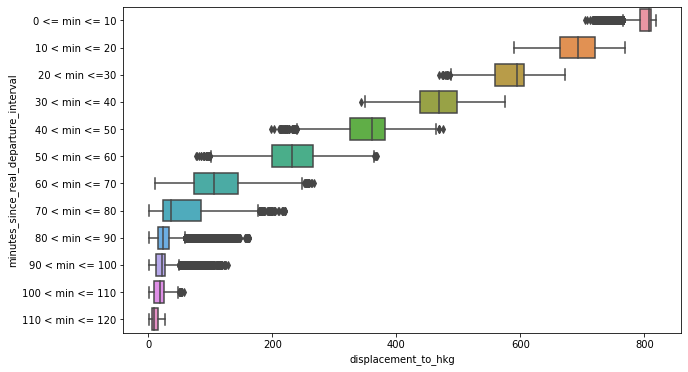

In [96]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='displacement_to_hkg',
            y='minutes_since_real_departure_interval',
            data=filtered_df)
plt.show()

In [97]:
filtered_df.dtypes

flight_id                                        object
timestamp_utc                                    object
latitude                                        float64
longitude                                       float64
altitude                                          int64
heading                                           int64
speed                                             int64
flight_callsign                                  object
aircraft_model                                   object
aircraft_registration                            object
airline                                          object
origin                                           object
destination                                      object
scheduled_departure_utc                         float64
scheduled_arrival_utc                           float64
real_departure_utc                              float64
estimated_arrival_utc                           float64
real_flight_duration                            

In [98]:
numeric_features = filtered_df.dtypes[(filtered_df.dtypes == np.int)|(filtered_df.dtypes == np.float)]
numeric_features = numeric_features.index.tolist()
numeric_features.remove('calculated_time_before_arrival')
print(numeric_features)
target_col = 'calculated_time_before_arrival'

['latitude', 'longitude', 'altitude', 'heading', 'speed', 'scheduled_departure_utc', 'scheduled_arrival_utc', 'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration', 'scheduled_arrival_year', 'scheduled_arrival_month', 'scheduled_arrival_day', 'scheduled_departure_year', 'scheduled_departure_month', 'scheduled_departure_day', 'scheduled_flight_duration', 'time_since_real_departure', 'prev_latitude', 'prev_longitude', 'calculated_flight_duration', 'displacement_to_hkg', 'displacement_fr_twn']


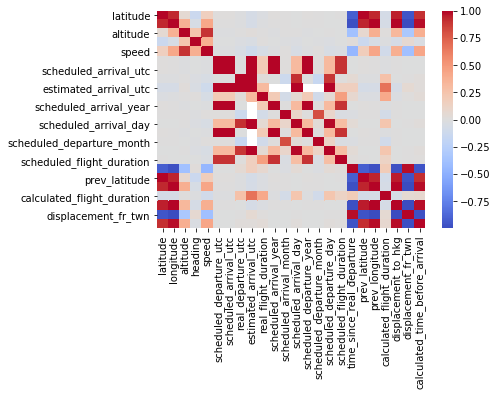

In [99]:
sns.heatmap(filtered_df[numeric_features + [target_col]].corr(), annot=False, cmap='coolwarm')

## Callsign

In [100]:
df_twn_hkg_with_flight_dur = pd.merge(df_twn_hkg,
                                      filtered_df[['flight_id', 'calculated_flight_duration']],
                                      on='flight_id').drop_duplicates()

In [101]:
df_twn_hkg_with_flight_dur['flight_callsign'] = df_twn_hkg_with_flight_dur['flight_callsign'].str.extract(r'([A-Z]*)')
df_twn_hkg_with_flight_dur['flight_callsign'].value_counts()

CPA    280
CAL    194
EVA    163
CRK     81
HDA     31
AHK     22
FDX      6
PAC      4
UPS      3
BR       2
NCA      1
HX       1
Name: flight_callsign, dtype: int64

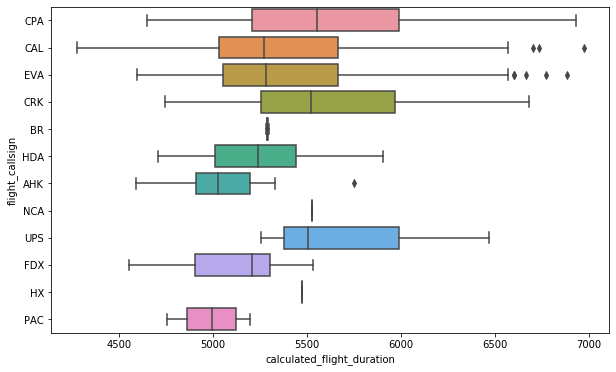

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='flight_callsign',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Airline

In [103]:
df_twn_hkg_with_flight_dur['airline'].value_counts(dropna=False).values.sum()

788

In [104]:
# set(df_twn_hkg_with_flight_dur['airline'].value_counts(dropna=False).index.map(lambda x: re.sub(r'\([^)]*\)', '', x).strip()))

In [105]:
df_twn_hkg_with_flight_dur['airline'] = df_twn_hkg_with_flight_dur['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

In [106]:
df_twn_hkg_with_flight_dur['airline'].value_counts()

Cathay Pacific           260
China Airlines           160
EVA Air                  133
Hong Kong Airlines        82
China Airlines Cargo      32
Cathay Dragon             31
Air Hong Kong             28
EVA Air Cargo             23
Cathay Pacific Cargo      11
Eva Air                    9
FedEx                      6
Polar Air Cargo            4
                           4
UPS                        3
Mandarin Airlines          1
Nippon Cargo Airlines      1
Name: airline, dtype: int64

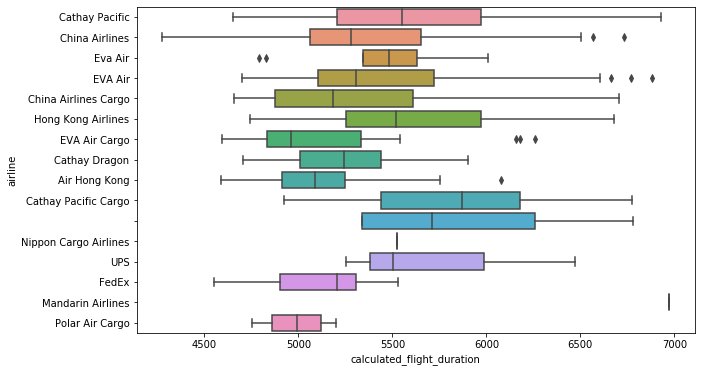

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='airline',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Aircraft Model

In [108]:
df_twn_hkg_with_flight_dur.aircraft_model.value_counts().sort_index()

                              4
Airbus A3004F-605R            5
Airbus A300B4-622R(F)         4
Airbus A300F4-605R           19
Airbus A320-232              12
Airbus A321-211             117
Airbus A321-231              11
Airbus A330-203               8
Airbus A330-223              17
Airbus A330-243              19
Airbus A330-243F             11
Airbus A330-302              66
Airbus A330-342              35
Airbus A330-343             147
Airbus A340-313              27
Airbus A350-941              90
Boeing 737-809                7
Boeing 737-8AL                8
Boeing 737-8FH                1
Boeing 737-8MA                4
Boeing 737-8Q8                2
Boeing 737-8SH                1
Boeing 747-409                1
Boeing 747-409(F)            32
Boeing 747-412(BCF)           1
Boeing 747-45E                1
Boeing 747-45E(BDSF)         12
Boeing 747-45EF(SCD)         11
Boeing 747-467F(ER)           8
Boeing 747-46N(F)             3
Boeing 747-47U(F)             1
Boeing 7

In [109]:
def get_aircraft_model(aircraft):
    if aircraft.find('Airbus') != -1:
        return aircraft[:11]
    elif aircraft.find('Boeing') != -1:
        return aircraft[:10]
    else:
        return aircraft
    
df_twn_hkg_with_flight_dur.aircraft_model = df_twn_hkg_with_flight_dur.aircraft_model.map(get_aircraft_model)

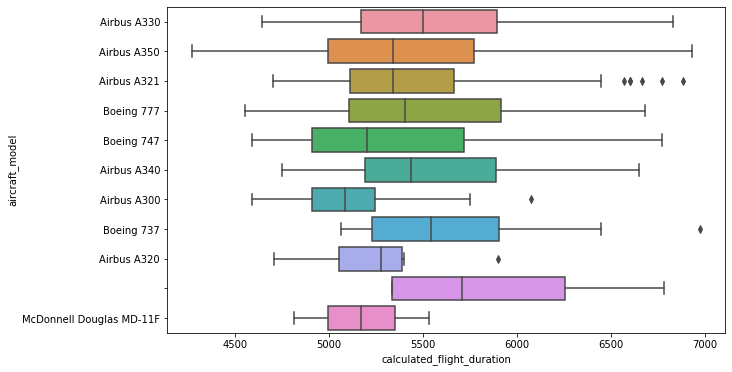

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='aircraft_model',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()

## Aircraft Registration

In [111]:
df_twn_hkg_with_flight_dur.aircraft_registration.value_counts().sort_index()

            4
B-16201     2
B-16203     9
B-16206     6
B-16208     1
B-16212     1
B-16215     8
B-16216    11
B-16217     4
B-16218     9
B-16219    10
B-16220     3
B-16221    13
B-16222     7
B-16223     8
B-16225    10
B-16226    10
B-16227     5
B-16310     2
B-16311     1
B-16312     5
B-16335     2
B-16336     1
B-16401     3
B-16406     9
B-16410     1
B-16481     5
B-16482     3
B-16483     3
B-16701     1
B-16702     3
B-16703     2
B-16708     1
B-16710     2
B-16712     1
B-16716     1
B-16717     2
B-18001     1
B-18007     1
B-18051     1
B-18053     1
B-18208     1
B-18301     9
B-18302     5
B-18303     1
B-18306     1
B-18307     2
B-18308     2
B-18309    13
B-18310     4
B-18312     2
B-18315     1
B-18316     1
B-18317     2
B-18351     7
B-18352     4
B-18353     4
B-18355     2
B-18358     1
B-18359     1
B-18360     1
B-18605     1
B-18606     2
B-18609     1
B-18610     2
B-18612     1
B-18651     1
B-18653     1
B-18655     3
B-18656     1
B-18657     1
B-1865

In [112]:
selected_features = ['latitude', 'longitude', 'altitude', 'heading', 'speed',
#                      'flight_callsign', 
#                      'aircraft_registration', 
                     'aircraft_model', 'airline']

nominal_features = [
    'flight_callsign', 
    'aircraft_registration',
    'aircraft_model', 
    'airline'
]

In [113]:
df_twn_hkg_with_flight_dur.columns

Index(['flight_id', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration',
       'scheduled_departure_dt', 'scheduled_arrival_dt', 'real_departure_dt',
       'estimated_arrival_dt', 'scheduled_arrival_year',
       'scheduled_arrival_month', 'scheduled_arrival_day',
       'scheduled_departure_year', 'scheduled_departure_month',
       'scheduled_departure_day', 'scheduled_flight_duration', 'route',
       'calculated_flight_duration'],
      dtype='object')

In [114]:
corr = filtered_df[numeric_features + [target_col]].corr()[target_col].sort_values()
corr[abs(corr.values) > 0.38]

displacement_fr_twn              -0.977494
time_since_real_departure        -0.964894
altitude                          0.388276
speed                             0.434193
latitude                          0.910920
prev_latitude                     0.915070
displacement_to_hkg               0.977985
prev_longitude                    0.981058
longitude                         0.981073
calculated_time_before_arrival    1.000000
Name: calculated_time_before_arrival, dtype: float64

## Save Data

In [115]:
filtered_df['flight_callsign'] = filtered_df['flight_callsign'].str.extract(r'([A-Z]*)')
filtered_df['airline'] = filtered_df['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())
filtered_df['aircraft_model'] = filtered_df.aircraft_model.map(get_aircraft_model)

In [116]:
filtered_df.to_csv('../data/filtered_flights_twn_hkg.csv')

## Plot of all flights that did not fly a holding pattern (Taiwan Taoyuan International Airport -> Hong Kong International Airport)

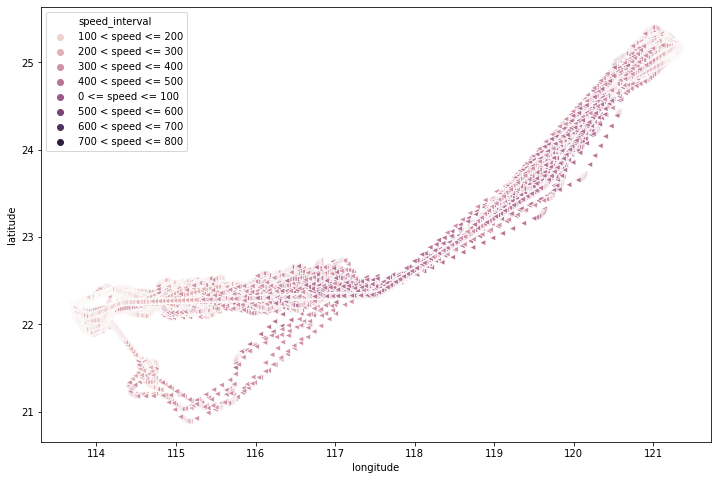

In [117]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
#                 palette=sns.color_palette("Blues", 8),
                palette=sns.cubehelix_palette(8),
                data=filtered_df)
plt.show();

In [118]:
# holding_stack_flight_ids = combined_jkt_sin.loc[combined_jkt_sin['latitude'] > 1.5, 'flight_id'].unique().tolist()

In [119]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(ax = ax, x='longitude', y='latitude', hue='speed_interval', marker='<',
# #                 palette=sns.color_palette("Blues", 8),
#                 palette=sns.cubehelix_palette(8),
#                 data=combined_jkt_sin[~combined_jkt_sin['flight_id'].isin(holding_stack_flight_ids)])
# plt.show();